In [ ]:
# @title Install Necessary Libraries

# Install required packages
!pip install --upgrade pylibjpeg pylibjpeg-libjpeg pydicom pillow
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# Download the SAM model checkpoint
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.4 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qig6y5f5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qig6y5f5
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=35e124cc18c771cd96d99eb11ae2543a8f026c997098f6885165e7a079d5fa13
  Stored in directory: /tmp/pip-ephem-wheel-cache-y08cq0a1/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-10-14 18:49:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicf

In [ ]:
# @title Import Libraries

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom
import pandas as pd
from segment_anything import sam_model_registry, SamPredictor
import itertools
from tqdm import tqdm

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True


In [ ]:
# @title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# @title Load the SAM Model

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the SAM model
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device)
predictor = SamPredictor(sam)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
# @title Define Helper Functions

def show_box(box, ax, edgecolor='green'):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor='none', lw=2))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # Dodger blue
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def apply_clahe_to_array(image_array, clip_limit, tile_grid_size):
    print(f"Applying CLAHE with clipLimit={clip_limit}, tileGridSize={tile_grid_size}")
    # Normalize image to 0-255 and convert to uint8
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=5)
    # Apply CLAHE
    clahe_image = clahe.apply(image_array) + 30
    return clahe_image

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    else:
        return intersection / union

def apply_canny_to_array(image):
    otsu_threshold, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lower_threshold = int(otsu_threshold * 0)
    upper_threshold = int(otsu_threshold * 0.25)
    edges = cv2.Canny(image, lower_threshold, upper_threshold)
    combined_image = cv2.addWeighted(image, 0.8, edges, 0.2, 0)
    return combined_image


In [ ]:
# @title Hyperparameter Tuning for CLAHE
import pandas as pd
# Define ranges for CLAHE hyperparameters
clip_limits = [1.0, 2.0, 3.0, 4.0, 5.0]
tile_grid_sizes = [(8, 8), (16, 16), (32, 32)]

best_hyperparams = None
best_average_iou = -1

# For storing results of different hyperparameter combinations
hyperparam_results = []

bounding_boxes_dict=pd.read_csv('/content/drive/MyDrive/rsna_pneumonia_detection_challenge/cleaned_train_data/cleaned_train_data.csv')

# Iterate over all combinations of hyperparameters
for clip_limit, tile_grid_size in itertools.product(clip_limits, tile_grid_sizes):
    print(f"Testing CLAHE with clipLimit={clip_limit}, tileGridSize={tile_grid_size}")

    ious_with_clahe = []
    sam_scores_with_clahe = []

    # Process all patients
    first_100_patients = list(bounding_boxes_dict.items())
    for patient_id, boxes in tqdm(first_100_patients, desc="Processing Patients"):
        # Read the DICOM file for the current patient_id
        print(patient_id)
        dcm_file_path = f'/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/{patient_id}.dcm'
        try:
            dicom = pydicom.dcmread(dcm_file_path)
        except Exception as e:
            print(f"Error reading DICOM file for patient {patient_id}: {e}")
            continue

        # Convert to grayscale image array
        image = dicom.pixel_array

        # Apply CLAHE with current hyperparameters
        clahe_image = apply_clahe_to_array(image, clip_limit=clip_limit, tile_grid_size=tile_grid_size)

        # Convert image to RGB
        clahe_image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)

        # Re-initialize the predictor for each image
        predictor = SamPredictor(sam)
        predictor.set_image(clahe_image_rgb)

        # Process with CLAHE
        predictor.set_image(clahe_image_rgb)
        for box in boxes:
            input_box = np.array(box)
            masks, scores, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=True
            )
            # Select the mask with the highest score
            best_idx = np.argmax(scores)
            best_mask = masks[best_idx]
            best_score = scores[best_idx]

            sam_scores_with_clahe.append(best_score)

            # Create approximate ground truth mask from bounding box
            gt_mask = np.zeros(clahe_image.shape, dtype=np.uint8)
            x1, y1, x2, y2 = map(int, box)
            gt_mask[y1:y2, x1:x2] = 1

            # Compute IoU between predicted mask and ground truth mask
            iou = compute_iou(best_mask, gt_mask)
            ious_with_clahe.append(iou)

    # Compute average IoU and SAM scores for current hyperparameters
    average_iou_with_clahe = np.mean(ious_with_clahe) if ious_with_clahe else 0
    average_score_with_clahe = np.mean(sam_scores_with_clahe) if sam_scores_with_clahe else 0

    print(f"Average IoU with CLAHE: {average_iou_with_clahe:.4f}")
    print(f"Average SAM Score with CLAHE: {average_score_with_clahe:.4f}\n")

    # Store results
    hyperparam_results.append({
        'clip_limit': clip_limit,
        'tile_grid_size': tile_grid_size,
        'average_iou': average_iou_with_clahe,
        'average_sam_score': average_score_with_clahe
    })

    # Update best hyperparameters if current IoU is better
    if average_iou_with_clahe > best_average_iou:
        best_average_iou = average_iou_with_clahe
        best_hyperparams = {
            'clip_limit': clip_limit,
            'tile_grid_size': tile_grid_size
        }

print("Best Hyperparameters for CLAHE:")
print(f"Clip Limit: {best_hyperparams['clip_limit']}")
print(f"Tile Grid Size: {best_hyperparams['tile_grid_size']}")
print(f"Best Average IoU: {best_average_iou:.4f}")

Testing CLAHE with clipLimit=1.0, tileGridSize=(8, 8)


Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 888.85it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2474.22it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2101.99it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2318.32it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2196.20it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2175.02it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2223.44it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2256.94it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2147.62it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2201.97it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 2337.70it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 1929.66it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 1875.81it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 1441.64it/s]


patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Testing CL

Processing Patients: 100%|██████████| 5/5 [00:00<00:00, 1997.48it/s]

patientId
Error reading DICOM file for patient patientId: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/patientId.dcm'
x1
Error reading DICOM file for patient x1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x1.dcm'
y1
Error reading DICOM file for patient y1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y1.dcm'
x2
Error reading DICOM file for patient x2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/x2.dcm'
y2
Error reading DICOM file for patient y2: [Errno 2] No such file or directory: '/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_stage_2_train_images/y2.dcm'
Average IoU with CLAHE: 0.0000
Average SAM Score with CLAHE: 0.0000

Best Hyper

In [ ]:
# @title Process Images and Compare Masks
%matplotlib inline
from PIL import Image
import glob
from pathlib import Path
import pandas as pd
# Initialize lists to hold IoU scores and SAM scores
ious_without_clahe = []
ious_with_best_clahe = []
ious_with_clahe_canny = []
ious_with_canny = []
sam_scores_without_clahe = []
sam_scores_with_best_clahe = []
sam_scores_with_clahe_canny = []
sam_scores_with_canny = []

images = glob.glob('/content/drive/MyDrive/SAM2_boundingBox/*/*.png')[:10]
bounding_boxes_dict=pd.read_csv('/content/drive/MyDrive/Pixel Perfect File/cleaned_train_data/cleaned_train_data.csv')
patients = list(bounding_boxes_dict.iterrows())

for image in images:
    patient_id = Path(image).stem[:-10]

    boxes = None
    pd = None

    for pid, b in patients:
        print(pid)
        if patient_id == pid:
            boxes = b
            break

    if boxes is None:
            break

    image = cv2.imread(image)
    #plt.imshow(image)
    #plt.show()

    #print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #image = np.array(image).astype(np.uint8)
    print(image.shape)
    # Apply best CLAHE
    clahe_image = apply_clahe_to_array(
        image,
        clip_limit=1.0,
        tile_grid_size=(32,32)
    )

    clahe_canny_image = apply_canny_to_array(
        clahe_image
    )

    # Convert images to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    clahe_image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)
    clahe_canny_image_rgb = cv2.cvtColor(clahe_canny_image, cv2.COLOR_GRAY2RGB)

    # Process without CLAHE
    predictor.set_image(image_rgb)

    for box in boxes:
        input_box = np.array(box)

        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=True
        )
        # Select the mask with the highest score
        best_idx = np.argmax(scores)
        best_mask = masks[best_idx]
        best_score = scores[best_idx]

        sam_scores_without_clahe.append(best_score)

        # Create approximate ground truth mask from bounding box
        gt_mask = np.zeros(image.shape, dtype=np.uint8)
        x1, y1, x2, y2 = map(int, box)
        gt_mask[y1:y2, x1:x2] = 1

        # Compute IoU between predicted mask and ground truth mask
        iou = compute_iou(best_mask, gt_mask)
        ious_without_clahe.append(iou)

    # Process with best CLAHE
    predictor.set_image(clahe_image_rgb)

    for box in boxes:
        input_box = np.array(box)

        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=True
        )
        # Select the mask with the highest score
        best_idx = np.argmax(scores)
        best_mask = masks[best_idx]
        best_score = scores[best_idx]

        sam_scores_with_best_clahe.append(best_score)

        # Create approximate ground truth mask from bounding box
        gt_mask = np.zeros(clahe_image.shape, dtype=np.uint8)
        x1, y1, x2, y2 = map(int, box)
        gt_mask[y1:y2, x1:x2] = 1

        # Compute IoU between predicted mask and ground truth mask
        iou = compute_iou(best_mask, gt_mask)
        ious_with_best_clahe.append(iou)

    predictor.set_image(Clahe_canny_image_rgb)

    for box in boxes:
        input_box = np.array(box)

        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=True
        )
        # Select the mask with the highest score
        best_idx = np.argmax(scores)
        best_mask = masks[best_idx]
        best_score = scores[best_idx]

        sam_scores_with_best_clahe_canny.append(best_score)

        # Create approximate ground truth mask from bounding box
        gt_mask = np.zeros(clahe_canny_image.shape, dtype=np.uint8)
        x1, y1, x2, y2 = map(int, box)
        gt_mask[y1:y2, x1:x2] = 1

        # Compute IoU between predicted mask and ground truth mask
        iou = compute_iou(best_mask, gt_mask)
        ious_with_best_clahe_canny.append(iou)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
# @title Compute Average IoUs and SAM Scores

# Compute average IoUs and SAM scores
average_iou_without_clahe = np.mean(ious_without_clahe) if ious_without_clahe else 0
average_iou_with_best_clahe = np.mean(ious_with_best_clahe) if ious_with_best_clahe else 0

average_score_without_clahe = np.mean(sam_scores_without_clahe) if sam_scores_without_clahe else 0
average_score_with_best_clahe = np.mean(sam_scores_with_best_clahe) if sam_scores_with_best_clahe else 0

print("\nSummary Statistics:")
print(f"Average IoU without CLAHE: {average_iou_without_clahe:.4f}")
print(f"Average IoU with Best CLAHE: {average_iou_with_best_clahe:.4f}")

print(f"Average SAM Score without CLAHE: {average_score_without_clahe:.4f}")
print(f"Average SAM Score with Best CLAHE: {average_score_with_best_clahe:.4f}")


Summary Statistics:
Average IoU without CLAHE: 0.4692
Average IoU with Best CLAHE: 0.3772
Average SAM Score without CLAHE: 0.7654
Average SAM Score with Best CLAHE: 0.7619


# Apply thresholding to CLAHE images to get edges

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 30


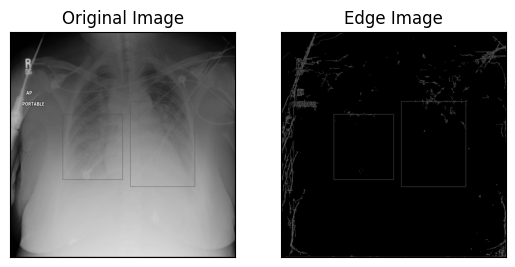

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 27


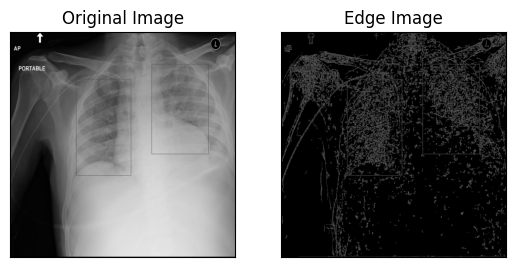

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 21


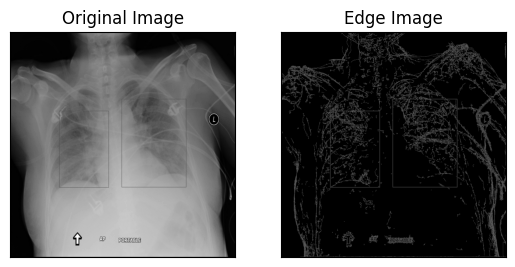

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 21


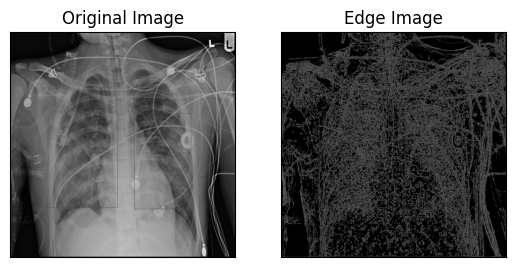

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 22


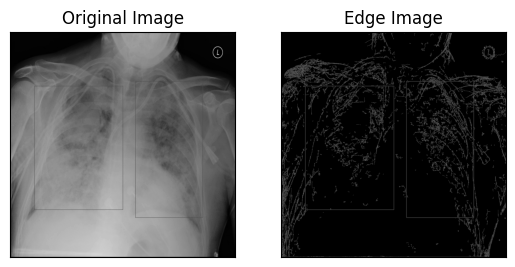

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 35


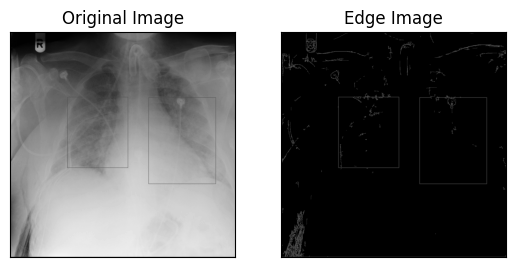

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


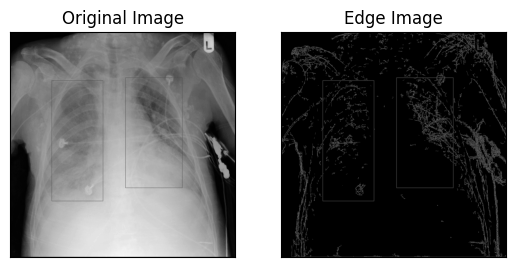

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 31


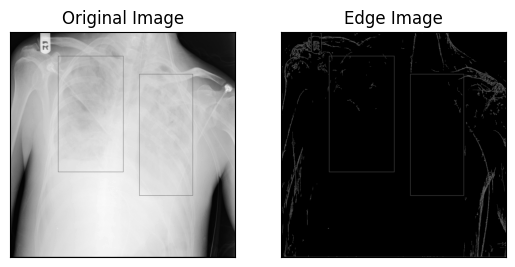

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 26


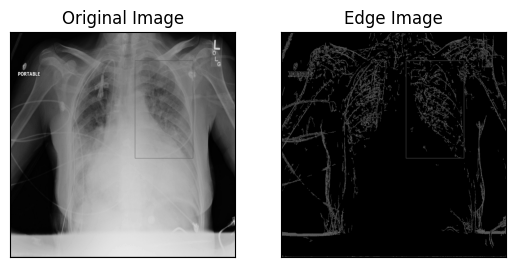

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


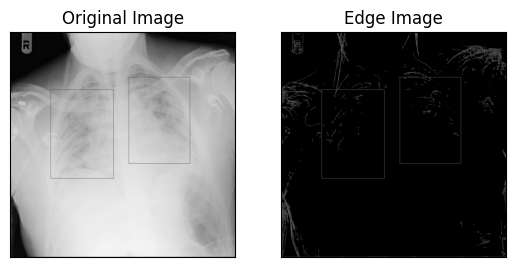

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 25


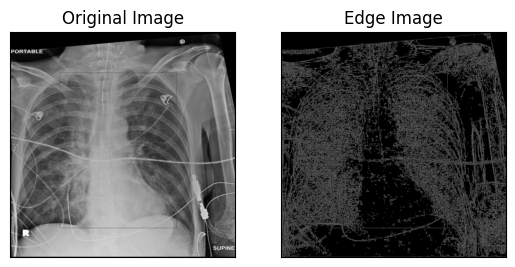

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 26


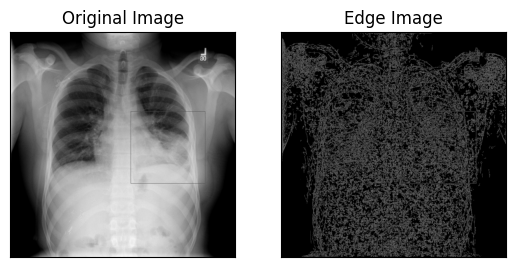

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


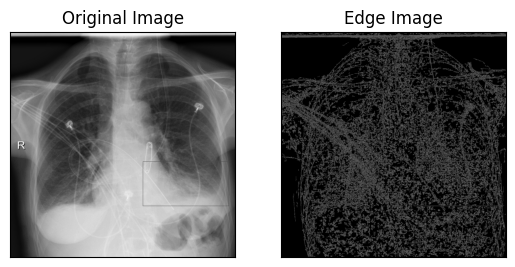

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 28


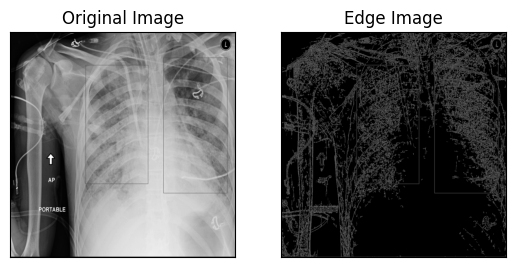

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 24


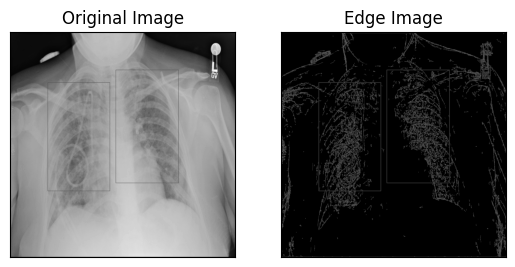

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 28


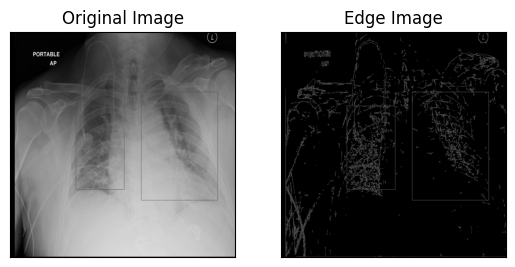

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 25


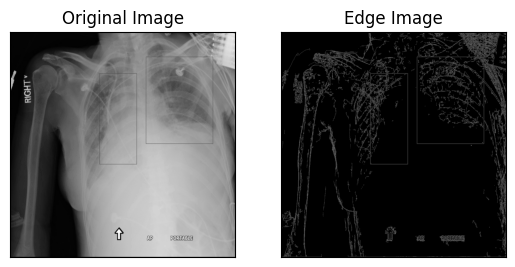

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 27


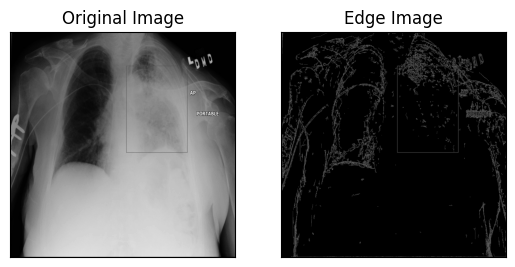

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 26


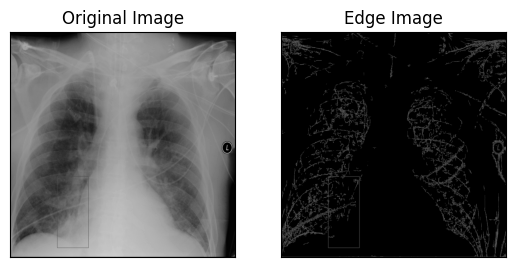

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 25


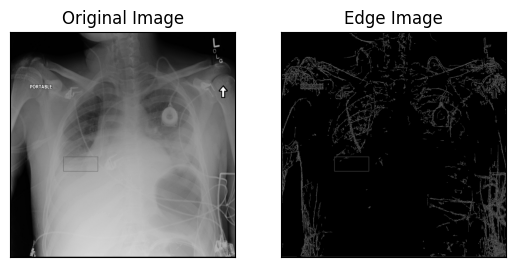

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 22


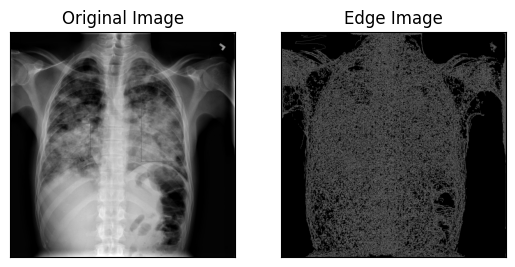

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


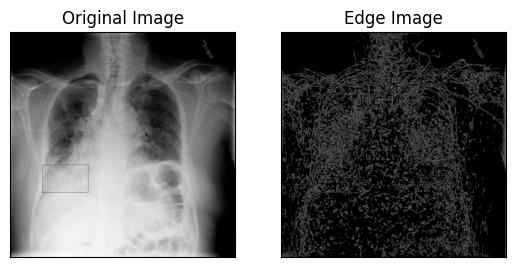

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 24


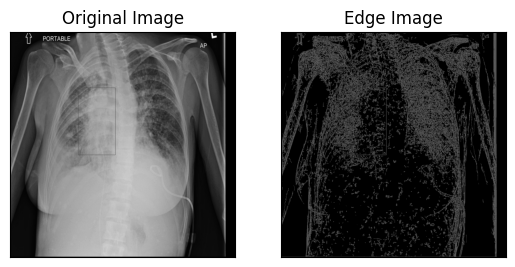

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 28


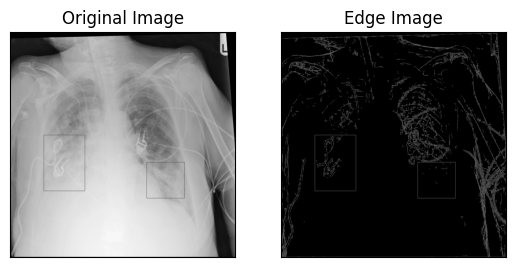

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 38


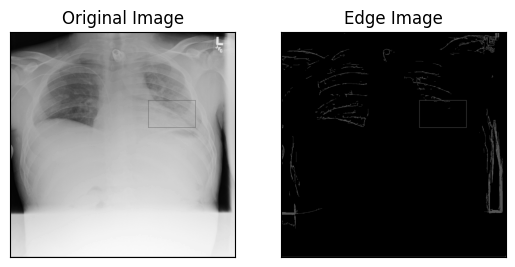

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 34


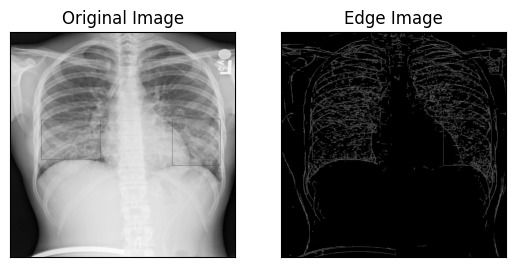

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


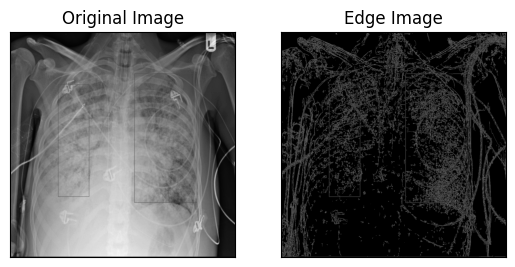

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 27


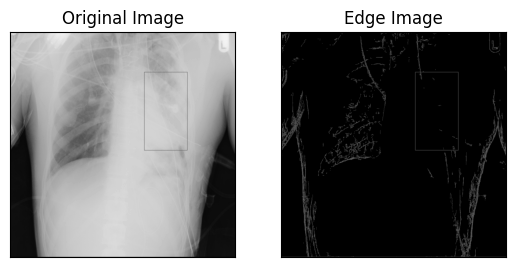

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 24


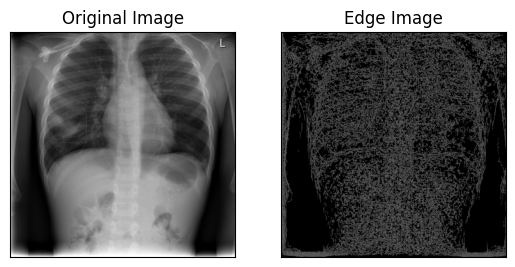

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


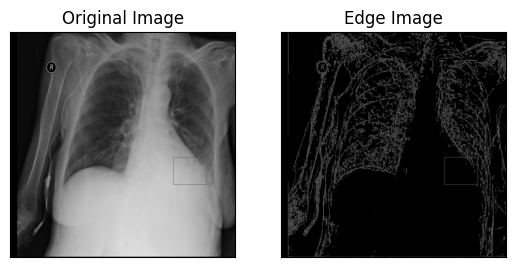

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 35


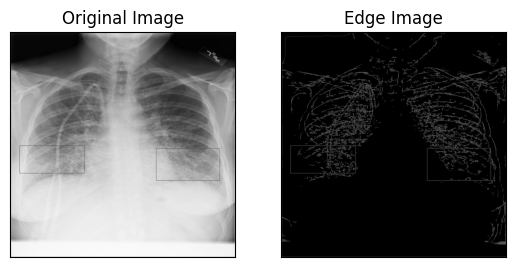

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 27


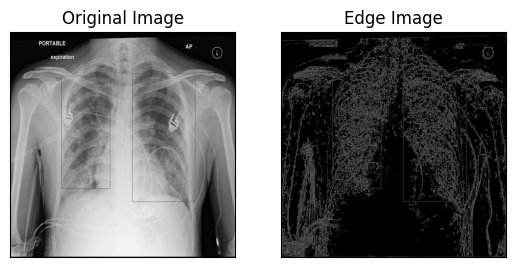

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 22


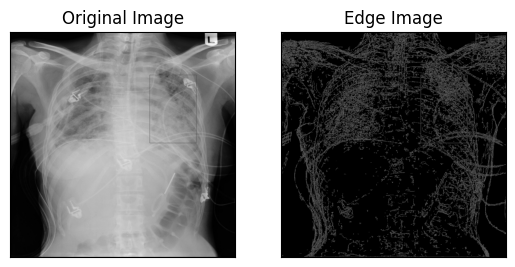

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 32


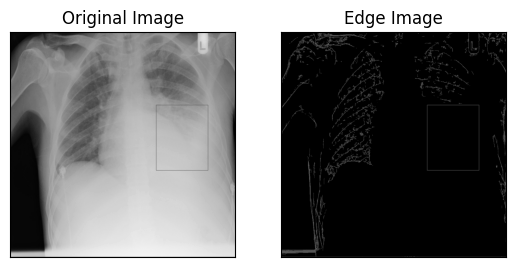

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


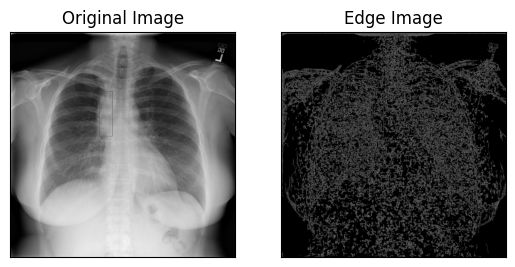

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 22


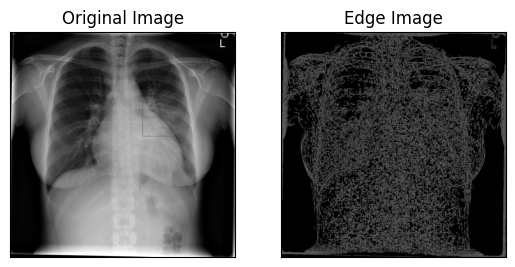

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 40


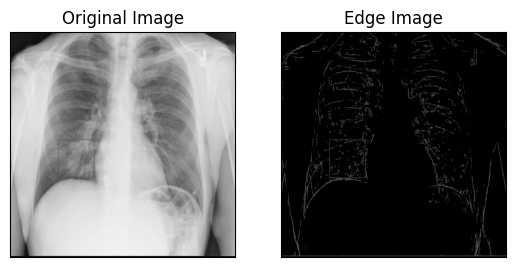

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


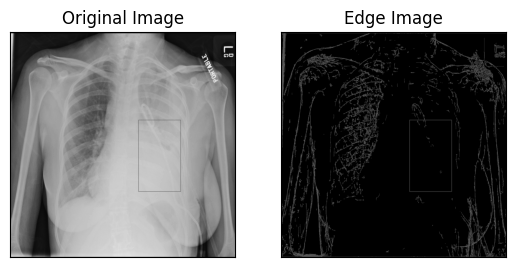

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 23


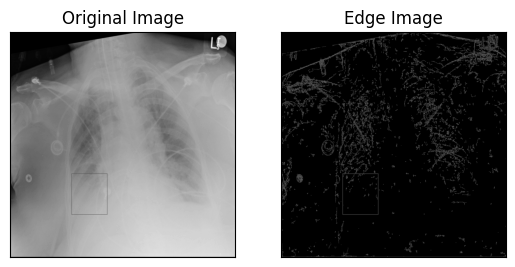

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 25


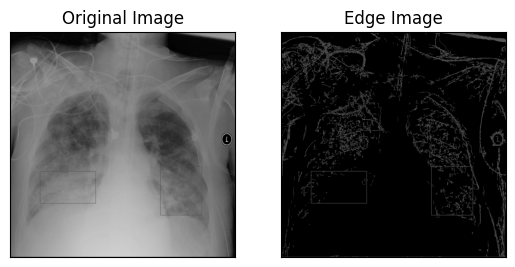

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 17


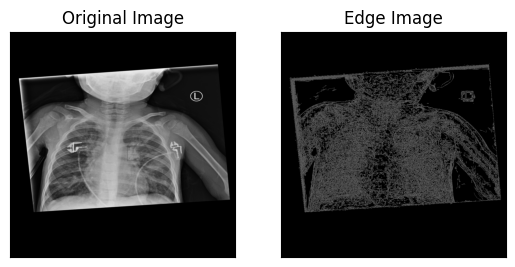

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 30


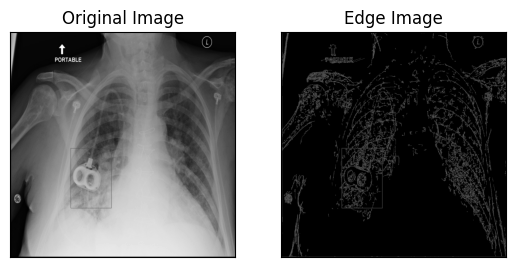

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 38


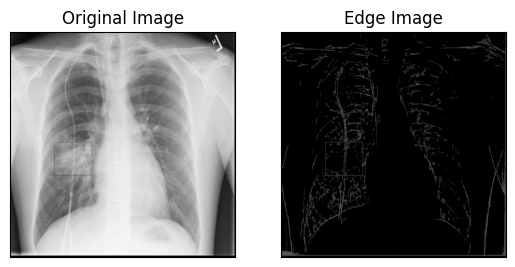

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 29


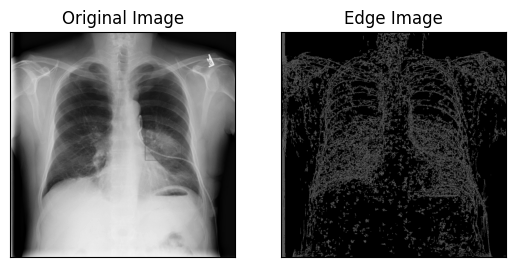

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 28


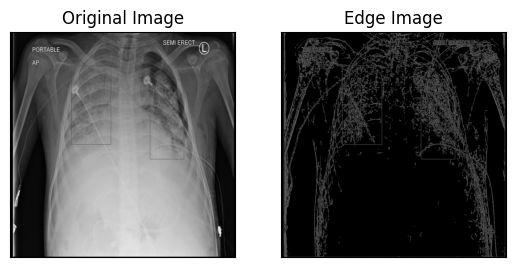

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 33


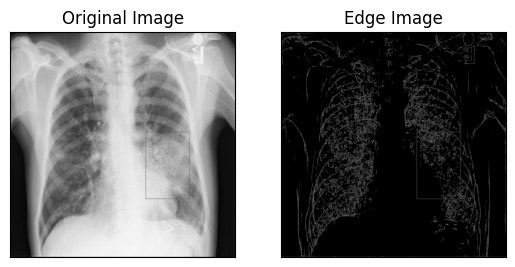

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 38


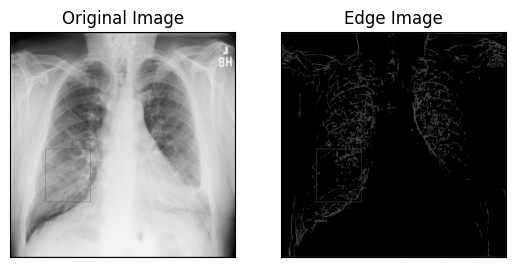

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 28


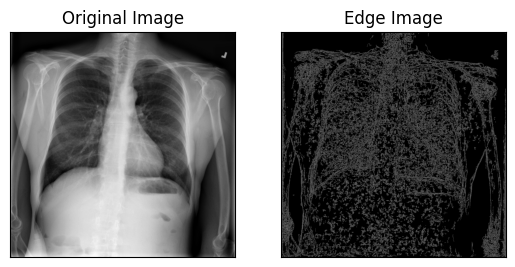

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 30


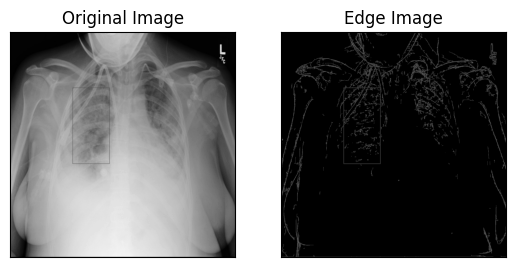

(3000, 3000)
Applying CLAHE with clipLimit=1.0, tileGridSize=(32, 32)
Lower Threshold: 0, Upper Threshold: 25


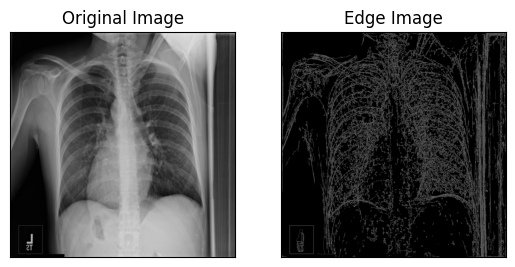

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import glob
import cv2

thresholds = [[ 10, 110]]
og_imgs = np.empty((10, 3000, 3000))
edge_imgs = np.empty((10, 3000, 3000))
j = 0

images = glob.glob('/content/drive/MyDrive/SAM2_boundingBox/*/*.png')[20:30]

for img in images:
  for i in range(len(thresholds)):
    image = cv2.imread(img)

    #plt.imshow(image)
    #plt.show()

    #print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #image = np.array(image).astype(np.uint8)
    print(image.shape)

    # Apply best CLAHE
    clahe_image = apply_clahe_to_array(
        image,
        clip_limit=1.0,
        tile_grid_size=(32,32)
    )

    """
    adaptive_thresh = cv2.adaptiveThreshold(image, 255,
                                        cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY,
                                        11, 2)

    mean, std_dev = cv2.meanStdDev(image)
    mean_value = mean[0][0]
    std_dev_value = std_dev[0][0]

    lower_threshold = int(max(0, mean_value - 0.5 * std_dev_value))
    upper_threshold = int(min(255, mean_value + 1.5 * std_dev_value))
    """

    otsu_threshold, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lower_threshold = int(otsu_threshold * 0)
    upper_threshold = int(otsu_threshold * 0.25)


  # Print the thresholds for debugging
    print(f"Lower Threshold: {lower_threshold}, Upper Threshold: {upper_threshold}")
    #assert img is not None, "file could not be read, check with os.path.exists()"
    edges = cv.Canny(image, lower_threshold, upper_threshold)

    #for box in boxes:
      #x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
      #cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)  # Red color with thickness 2
      #cv2.rectangle(edges, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    og_imgs[j] = image
    edge_imgs[j] = edges
    j += 1

    plt.figure()
    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    #plt.savefig(f"/content/drive/My Drive/threshold_images2/{patient_id}.png")
    plt.show()


# Combine edges with original image

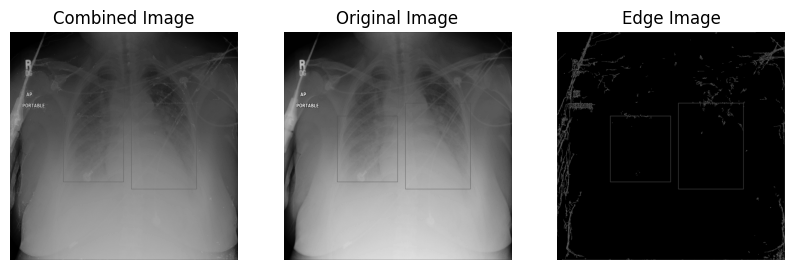

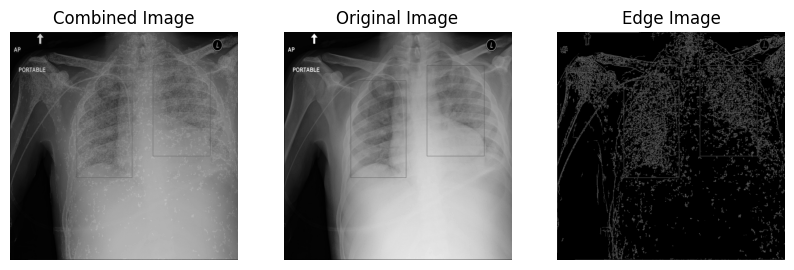

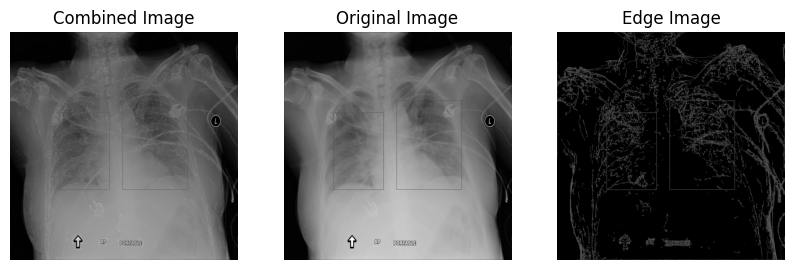

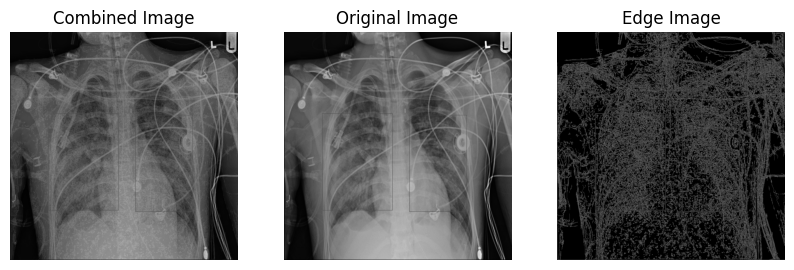

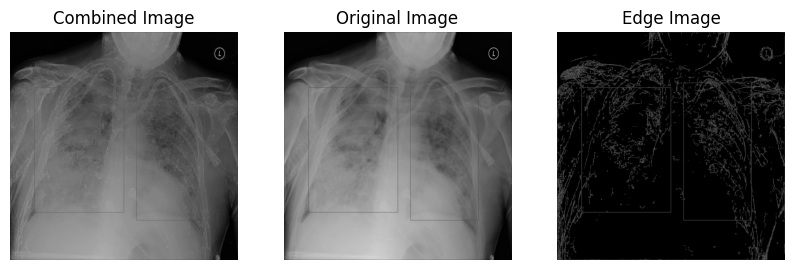

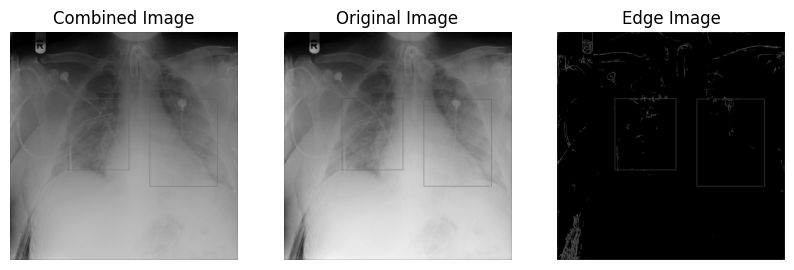

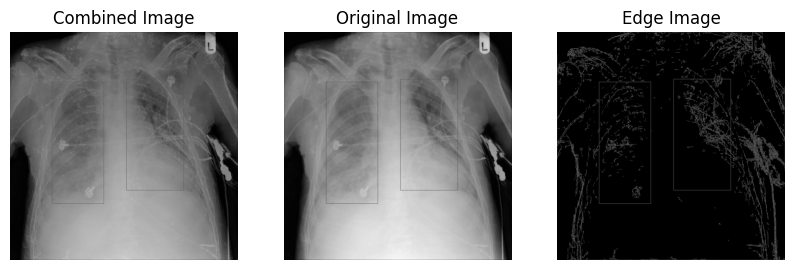

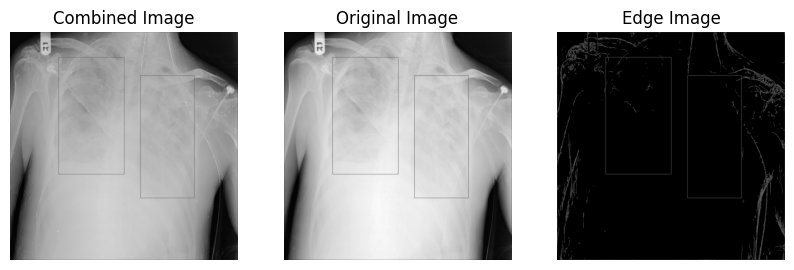

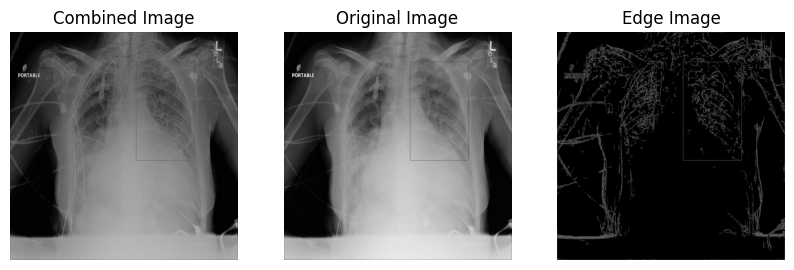

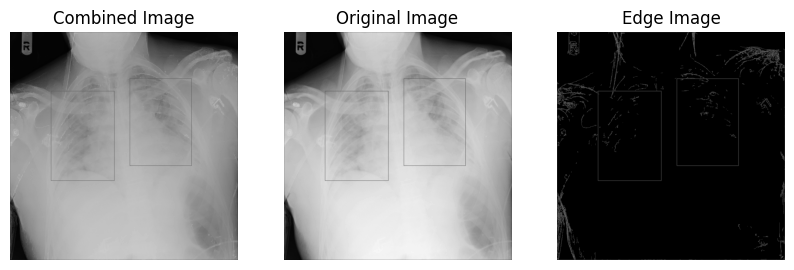

In [ ]:
for i in range(10):
    # Combine the original image and the edge-detected image
    combined_image = cv2.addWeighted(og_imgs[i], 0.8, edge_imgs[i], 0.2, 0)


    predictor = SamPredictor(sam)
    predictor.set_image(combined_img)
    predictor.predict()

    #print(f"Image {i}")
    # Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(141)
    plt.title('Combined Image')
    plt.axis('off')
    plt.imshow(combined_image, cmap='gray')
    plt.subplot(142),plt.imshow(og_imgs[i],cmap = 'gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(143),plt.imshow(edge_imgs[i],cmap = 'gray')
    plt.title('Edge Image')
    plt.axis('off')


    plt.subplot(144)
    plt.title('Segmentation Results')
    plt.imshow(segmentation_results)
    plt.axis('off')

    plt.savefig(f"/content/drive/My Drive/thresholded_images/Image{i}.png")
    plt.show()

In [ ]:
predictor = SamPredictor(sam)
predictor.set_image(clahe_image_rgb)

# Process with CLAHE
predictor.set_image(clahe_image_rgb)
for box in boxes:
    input_box = np.array(box)
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=True
    )

# Create approximate ground truth mask from bounding box
gt_mask = np.zeros(image.shape, dtype=np.uint8)
x1, y1, x2, y2 = map(int, box)
gt_mask[y1:y2, x1:x2] = 1

# Compute IoU between predicted mask and ground truth mask
iou = compute_iou(best_mask, gt_mask)
ious_without_clahe.append(iou)